In [ ]:
!pip install openpyxl==3.0.5

#Libraries Import

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import matplotlib.image  as mpimg
from google.colab import files
import seaborn as sns
from tensorflow.keras.metrics import mean_absolute_error

#Dataset

In [66]:
# Uncomment below line of code if using google colab.
# files.upload()

df = pd.read_excel('Data_set_v2.xlsx')      #Read CSV data file
calls_data = df['No_calls_Offered']         #Get daily calls data
days = np.arange(len(calls_data))           #Call days

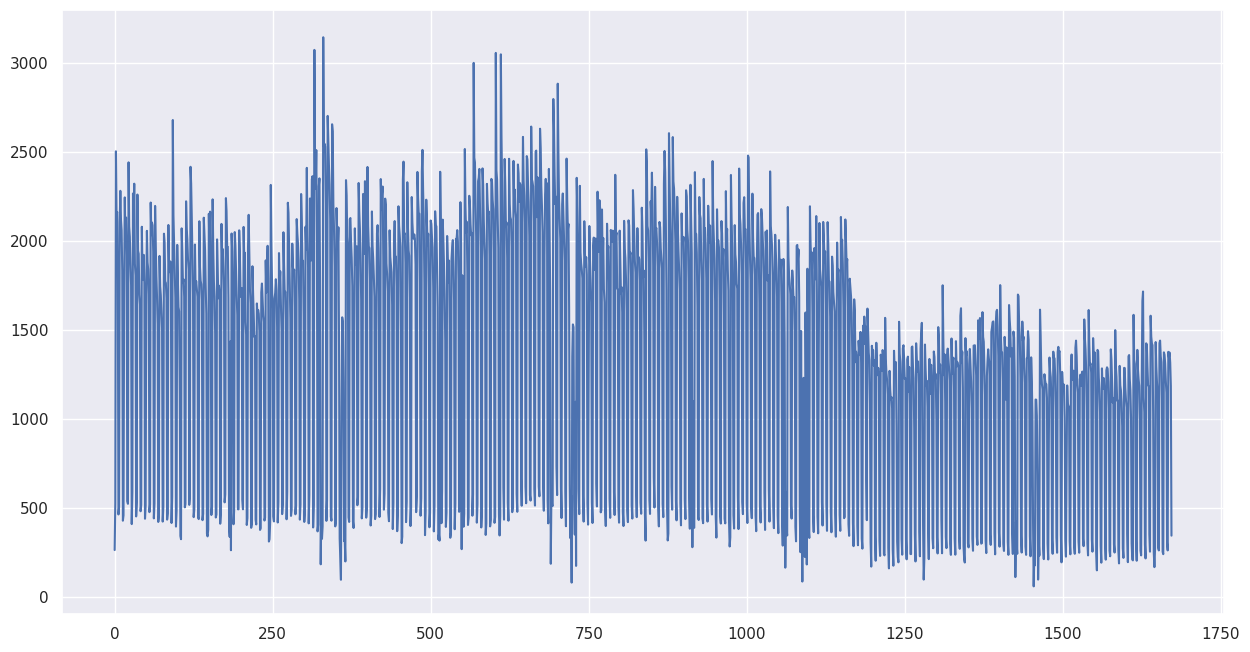

In [67]:
#Visualization
plt.figure(figsize=(15,8), dpi=100)
a=1000
# plt.plot(days[:a], calls_data[:a])
plt.plot(days, calls_data)

#Train/Test Split

In [68]:
#Notice that the data is split into 80/20 portions

split = int(len(days)*0.9465)    #Split interval 
x_train = calls_data[:split]  #Training Set

days_valid = days[split:]
x_valid = calls_data[split:]  #Test set

#Data Preprocessing

In [69]:
'''
The below function is used to create the training data. Since the entire 
call data cannot be fed at once into the model, thus the data needs to be 
segmented into shorter windows with which the model could be trained. The
function below is used for this purpose.'''


def segmented_dataset(daily_calls, Window, batches, shuffle_buffer):
  data_gen = tf.data.Dataset.from_tensor_slices(daily_calls)
  data_gen = data_gen.window(Window + 1, shift=1, drop_remainder=True)
  data_gen = data_gen.flat_map(lambda window: window.batch(Window + 1))
  data_gen = data_gen.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  data_gen = data_gen.batch(batches).prefetch(1)
  return data_gen

window = 21       #Length of the window segment
batches = 32      #Data batches
buffer = 1000     #Shuffle buffer

#Creating the segmented training set
train_dataset = segmented_dataset(x_train, window, batches, buffer)

#Model Designing

In [70]:
''' The model is designed using the sequential API in keras having
tensorflow backend. The model contains dense layers with number 
of neurons specified as input. The loss function used is the 
Mean Squared Error (MSE) while the optimizer used is Adaptive 
Moment Estimation (ADAM). The performance metric is Mean 
Absolute Error (MAE).'''

#Model Architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2056, input_shape=[window], activation="relu"), 
    tf.keras.layers.Dense(1028, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(256, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#Model compilation
model.compile(loss="mse", optimizer='adam',metrics=["mae"])

#Model Training

In [71]:
epochs = 100    #Training iterations

#Model trianing
history = model.fit(train_dataset,epochs=epochs,verbose=1)

Epoch 1/100
49/49 [==============================] - 1s 8ms/step - loss: 281132.8438 - mae: 349.2812
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 96131.1953 - mae: 180.4769
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 99821.3047 - mae: 192.1653
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: 97953.4375 - mae: 193.3766
Epoch 5/100
49/49 [==============================] - 1s 8ms/step - loss: 84132.1406 - mae: 165.9824
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 84090.9844 - mae: 164.1823
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 85461.6172 - mae: 173.9012
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 78374.9062 - mae: 151.9741
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 94041.1953 - mae: 192.4374
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 84238.2109 - mae: 167.21

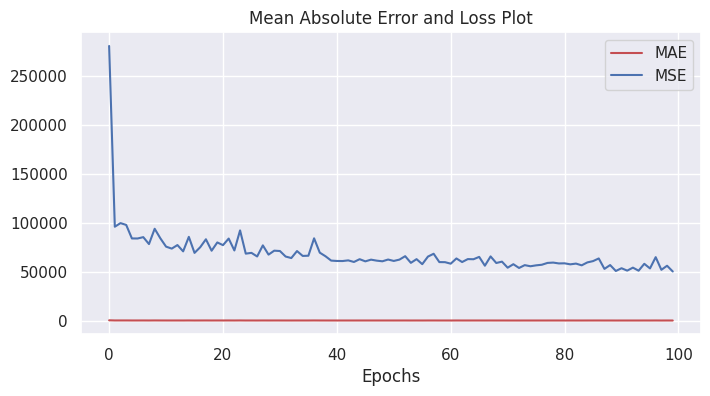

In [72]:
#Get the loss function and performance metric values
mean_absolute_error=history.history['mae']
mse=history.history['loss']

iteration=range(len(mse))   #Number of iterations

#Plotting the loss and mae vs number of iterations
plt.figure(figsize=(8,4), dpi=100)
plt.plot(iteration, mean_absolute_error, 'r')
plt.plot(iteration, mse, 'b')
plt.title('Mean Absolute Error and Loss Plot')
plt.xlabel("Epochs")
plt.legend(["MAE", "MSE"])

#Forecasting and Model Evaluation

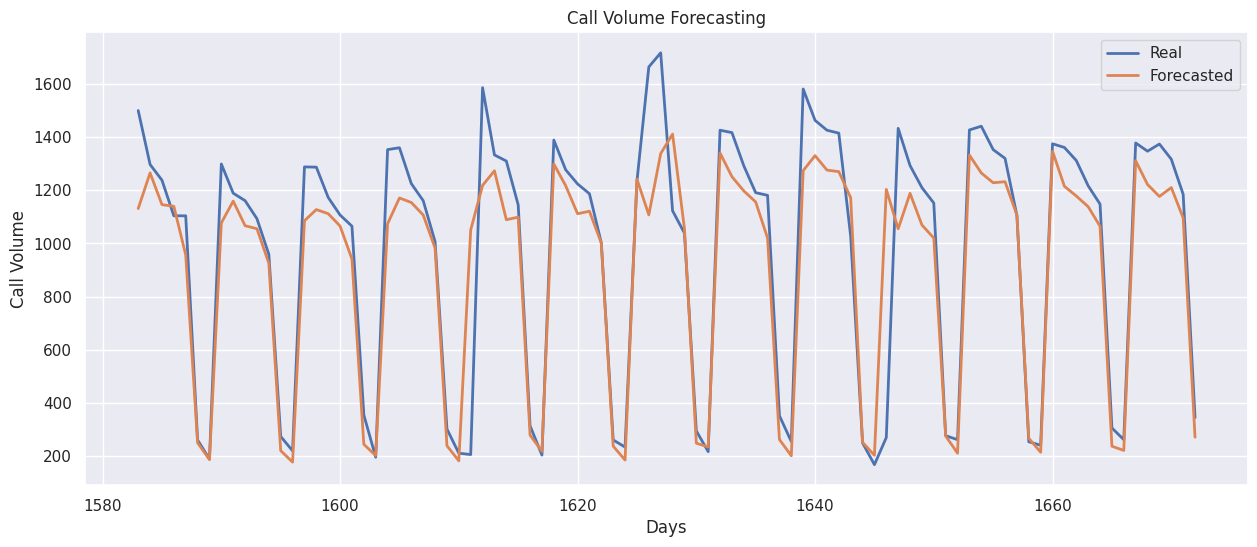

In [73]:
calls_forecast = []    #Empty array

#Loop over the data
for day in range(len(calls_data) - window):
  calls_forecast.append(model.predict(np.expand_dims(calls_data[day:day + window], axis=0)))

#Storing result of forecasting
calls_forecast = calls_forecast[split-window:]
calls_forecast_array = np.array(calls_forecast)[:, 0, 0]

#Plotting Forecasted Calls volume
sns.set_theme()
plt.figure(figsize=(15, 6), dpi=100)
plt.plot(days_valid, x_valid, "-", linewidth=2);
plt.plot(days_valid, calls_forecast_array, "-", linewidth=2);
plt.xlabel("Days")
plt.ylabel("Call Volume")
plt.title("Call Volume Forecasting")
plt.grid(True)
plt.legend(["Real", "Forecasted"]);

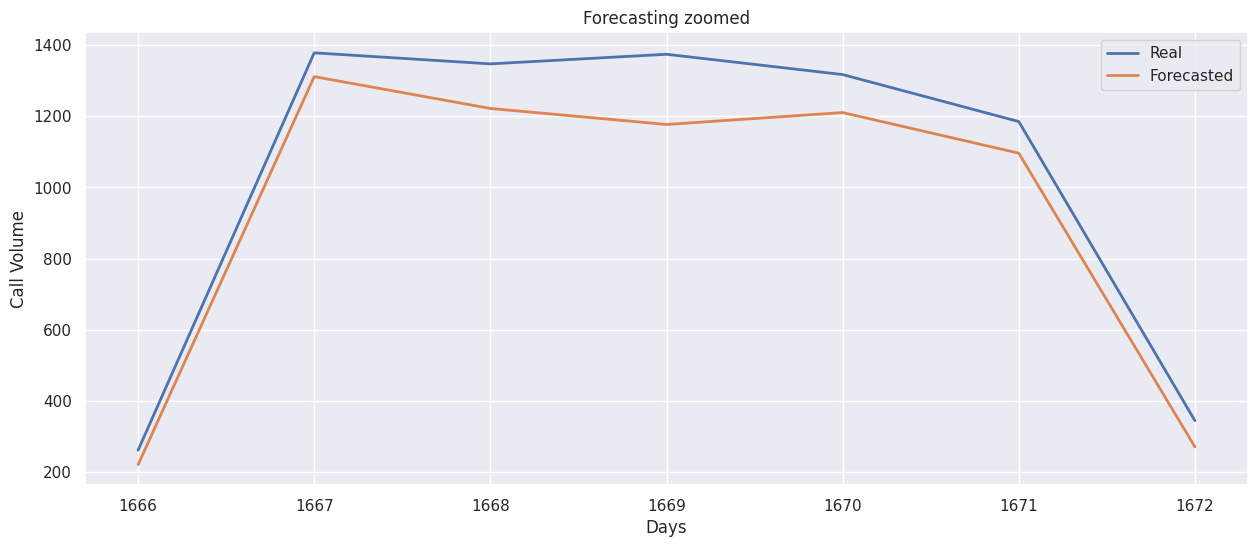

In [89]:
plt.figure(figsize=(15, 6), dpi=100)
# plt.fill_between(x=days_valid[10:20],
#                  y1=x_valid[10:20]+250,
#                  y2=x_valid[10:20]-240,
#                  alpha=0.6
#                  )
plt.plot(days_valid[len(x_valid)-7:], x_valid[len(x_valid)-7:], "-", linewidth=2);
plt.plot(days_valid[len(x_valid)-7:], calls_forecast_array[len(x_valid)-7:], "-", linewidth=2);
plt.xlabel("Days")
plt.ylabel("Call Volume")
plt.title('Forecasting zoomed')
plt.grid(True)
plt.legend(["Real", "Forecasted"]);

#Export to CSV

In [ ]:
#Save the forecasted data to a CSV file
np.savetxt("calls_forecast.csv", calls_forecast_array, delimiter=",")

In [75]:
(1/len(x_valid))*sum(abs(x_valid-calls_forecast_array)/abs(x_valid))*100

19.124433154028875

In [92]:
year = [2021, 2021, 2021, 2021, 2021, 2021, 2021]
month = [1, 1, 1, 1, 1, 1, 1]
day = [1, 2, 3, 4, 5, 6, 7]

data = {'year':year, 'month':month, 'day':day}
week_prediction = pd.DataFrame(data = pd.to_datetime( pd.DataFrame(data=data) ), columns = ['Date'])
week_prediction['No_calls_Offered_predicted'] = calls_forecast_array[len(x_valid)-7:]
week_prediction


,Date,No_calls_Offered_predicted
0,2021-01-01,221.474091
1,2021-01-02,1311.226562
2,2021-01-03,1221.807251
3,2021-01-04,1176.755737
4,2021-01-05,1210.318237
5,2021-01-06,1096.292603
6,2021-01-07,271.335907
